In [1]:
import sys
import math
import numpy as np
import pandas as pd
import pyhdf as hdf4
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import stats
import cartopy.crs as ccrs

In [2]:
#Read HDF4 file to a dictionary d
def read_sds(filename):
 import pyhdf.SD as H
 out={}
 a=H.SD(filename)
 dic=a.datasets()
# print( dic)
 keys=dic.keys()
 for n in keys:
#   print (n)
   sd=a.select(n)
   d=sd.get()
   out[n]=d
 return out

In [3]:
#Assign histogram bin edge values for each column name in a pandas dataframe
# return dictionaries dict_bins and dict_log (Boolean: using log-scale or not)
def bins_dfs(df1):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import math
    #create dict_log for using log scale or not in histogram bins
    #nbins Default number of bins
    keys = list(df1)
    dict_bins = {}
    dict_log = {}
    for i in range(len(keys)):
        min = df1[keys[i]].values.min()
        max = df1[keys[i]].values.max()
  #      print('key,min,max=',keys[i],min,max)
        nbins = 30
        if min <= 0.0:
            if keys[i] == "LON" or keys[i] == "R_LON":
                min1= math.floor(min)
                max1 = math.ceil(max)
                nbins = int((max1-min1)/2.0)+ 1
                bins = np.linspace(min1,max1,nbins)
                dict_bins[keys[i]] = bins
                dict_log[keys[i]]  = False
            elif keys[i] == "LAT" or keys[i] == "R_LAT" or keys[i]=="R_ORIENTATION":
                min1 = math.floor(min)
                max1 = math.ceil(max)
                nbins = int((max1-min1)/2.0) + 1
                bins = np.linspace(min1,max1,nbins)
                dict_bins[keys[i]] = bins
                dict_log[keys[i]]  = False
            elif keys[i] == "RAINGRID_5" or keys[i] == "VOLRAINGRID_5" or keys[i]=="RAINAREA_5" or keys[i] == "VOLRAIN_5":
                #log bins
                min1 = 0.0
                max1 = math.ceil(math.log10(max))
                bins = np.logspace(min1,max1,nbins)
                dict_bins[keys[i]] = bins
                dict_log[keys[i]]  = True   
            else:
                #linear bins
                bins = np.linspace(min,max,nbins)
                dict_bins[keys[i]] = bins
                dict_log[keys[i]]  = False
        elif keys[i] == "YEAR":
            bins = np.linspace(2010, 2022, 13)
            dict_bins[keys[i]] = bins
            dict_log[keys[i]]  = False
        elif keys[i] == "MONTH":
            bins = np.linspace(1, 12, 12)
            dict_bins[keys[i]] = bins
            dict_log[keys[i]]  = False
        elif keys[i] == "DAY":
            bins = np.linspace(1, 31, 31)
            dict_bins[keys[i]] = bins
            dict_log[keys[i]]  = False
        elif keys[i] == "HOUR":
            bins = np.linspace(1, 24, 24)
            dict_bins[keys[i]] = bins
            dict_log[keys[i]]  = False
        elif keys[i] == "R_MINOR" or keys[i] == "R_MAJOR":
                bins =  np.logspace(1.,4.,nbins)
                dict_bins[keys[i]] = bins
                dict_log[keys[i]]  = True# log bins
        else:
            min1 = math.floor(math.log10(min))
            max1 = math.ceil(math.log10(max))
            bins = np.logspace(min1,max1,nbins)
            dict_bins[keys[i]] = bins
            dict_log[keys[i]]  = True
    #print('dict_log=',dict_log)
    #print('dict_bins=',dict_bins)
    return dict_bins,dict_log

In [4]:
# 1D histogram comparisions and plots for each variable in the arg_list
def hist1d_dfs(df1,df2,df1_name,df2_name,dict_bins,dict_log,arg_list):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import math
    print("Inside hist1d_dfs: arg_list =",arg_list) 
    n = 0
    for x in arg_list:
        name = x
        var1 = df1[x].to_numpy()
        var2 = df2[x].to_numpy()
        xlog = dict_log[x]
        xbin = dict_bins[x]
        
        i = n % 4
        if i == 0 :
            fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(10,8))
    
        ax=axes.flatten()[i]
        ax.hist((var1,var2),bins=xbin,log=xlog,alpha=0.5,color=('red','blue'),
                label=(df1_name,df2_name))
        ax.legend(prop={'size': 10})
        if xlog:
           ax.set_xscale('log')
        ax.set_title(name)
        ax.set_xlabel(name)
        ax.set_ylabel("PF Counts")
        ax.set_yscale('log')
        
        if i == 3 or n == len(arg_list)-1:
            title = "Comparison of " + df1_name +" and " + df2_name + " Popolation (counts)"
            fig.suptitle(title)
            fig.tight_layout()
            plt.show()
        n = n+1
    return

In [5]:
# 2D histogram comparisions and plots for each pair in the arg_list
def hist2d_dfs(df1,df2,df1_name,df2_name,dict_bins,dict_log,arg_list):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import math
    
    print("Inside hist2d_dfs arg_list =", arg_list)
    n = 0
    for x in arg_list:
#        print(type(x),x)
        xname = x[0]
        yname = x[1]
#        print('xname=',xname,'yname=',yname)
        xvar1 = df1[xname].to_numpy()
        xvar2 = df2[xname].to_numpy()
        yvar1 = df1[yname].to_numpy()
        yvar2 = df2[yname].to_numpy()
        xlog  = dict_log[xname]
        xbin  = dict_bins[xname]
        ylog  = dict_log[yname]
        ybin  = dict_bins[yname]
#        
        i = n % 2
        if i == 0 :
            fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(10,12))
            ax=axes.flatten()[i]
            hist1,xedges,yedges,im=ax.hist2d(xvar1,yvar1,bins=[xbin,ybin],density=True,alpha=1.0,
                                             norm=colors.LogNorm(),cmap="hot")            
#            print("hist1:",hist1.min(),hist1.max(),hist1.shape,xedges.shape,yedges.shape)
            if xlog:
                ax.set_xscale('log')
            if ylog:
                ax.set_yscale('log')
            ax.set_title(df1_name+" NORMAILIZED 2D HISTOGRAM")
            ax.set_xlabel(xname)
            ax.set_ylabel(yname)
            im.set_clim(1.0e-3,1.e-12)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')
            
            ax=axes.flatten()[i+2]
            hist2,xedges,yedges,im=ax.hist2d(xvar2,yvar2,bins=[xbin,ybin],density=True,alpha=1.0,
                                             norm=colors.LogNorm(),cmap="hot")
#            print("hist2:",hist2.min(),hist2.max(),hist2.shape,xedges.shape,yedges.shape)
            
            if xlog:
                ax.set_xscale('log')
            if ylog:
                ax.set_yscale('log')
            ax.set_title(df2_name+" NORMAILIZED 2D HISTOGRAM")
            ax.set_xlabel(xname)
            ax.set_ylabel(yname)
            im.set_clim(1.0e-3,1.e-12)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')
            
            ax=axes.flatten()[i+4]
#            print("xedges=",xedges)
#            print("yedges=",yedges)
            diff=(hist2-hist1).T
#            print("diff=",type(diff),diff.shape)
          #  ax.pcolormesh(xedges, yedges, diff)
            cntr=ax.contourf(xedges[0:-1],yedges[0:-1],diff,levels=14,cmap="RdBu_r")
          #  norm=colors.LogNorm(),cmap="RdBu_r")
            fig.colorbar(cntr,ax=ax)
            if xlog:
                ax.set_xscale('log')
            if ylog:
                ax.set_yscale('log')
            ax.set_title(df2_name+" - "+df1_name)
            ax.set_xlabel(xname)
            ax.set_ylabel(yname)
            
        else:
            #fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(10,12))
            ax=axes.flatten()[i]
 #           hist1,xedges,yedges,im=ax.hist2d(xvar1,yvar1,bins=[xbin,ybin],log=[xlog,ylog],density=True,alpha=0.5,
            hist1,xedges,yedges,im=ax.hist2d(xvar1,yvar1,bins=[xbin,ybin],density=True,alpha=1.0,
                                 norm=colors.LogNorm(),cmap="hot")            
#            print("hist1:",hist1.min(),hist1.max(),hist1.shape,xedges.shape,yedges.shape)
            if xlog:
                ax.set_xscale('log')
            if ylog:
                ax.set_yscale('log')
            ax.set_title(df1_name+" NORMAILIZED 2D HISTOGRAM")
            ax.set_xlabel(xname)
            ax.set_ylabel(yname)
            im.set_clim(1.0e-3,1.e-12)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')
            
            ax=axes.flatten()[i+2]
            hist2,xedges,yedges,im=ax.hist2d(xvar2,yvar2,bins=[xbin,ybin],density=True,alpha=1.0,
                      norm=colors.LogNorm(),cmap="hot")
#            print(type(hist1),hist1.shape,xedges.shape,yedges.shape)
            if xlog:
                ax.set_xscale('log')
            if ylog:
                ax.set_yscale('log')
            ax.set_title(df2_name+" NORMAILIZED 2D HISTOGRAM")
            ax.set_xlabel(xname)
            ax.set_ylabel(yname)
            im.set_clim(1.0e-3,1.e-12)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical')
            
            ax=axes.flatten()[i+4]
#            print("xedges=",xedges)
#            print("yedges=",yedges)
            diff=(hist2-hist1).T
#            print("diff=",type(diff),diff.shape)
          #  ax.pcolormesh(xedges, yedges, diff)

            cntr=ax.contourf(xedges[0:-1],yedges[0:-1],diff,levels=14,cmap="RdBu_r")
           # cntr=ax.contourf(xedges[0:-1],yedges[0:-1],diff,levels=14, norm=colors.LogNorm(),cmap="RdBu_r")
            fig.colorbar(cntr,ax=ax)
            if xlog:
                ax.set_xscale('log')
            if ylog:
                ax.set_yscale('log')
            ax.set_title(df2_name+" - "+df1_name)
            ax.set_xlabel(xname)
            ax.set_ylabel(yname)
                           
        if i == 1 or n == len(arg_list)-1:
            title = "Comparison of " + df1_name +" and " + df2_name + " 2D Histogram"
            fig.suptitle(title)
            fig.tight_layout()
            plt.show()
        n = n+1
    return

In [6]:
# Local contribution histogram comparisions and plots for each pair in the arg_list
def loc_contri_dfs(df1,df2,df1_name,df2_name,dict_bins,dict_log,arg_list):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import math
    
    lon1 = df1["LON"].to_numpy()
    lat1 = df1["LAT"].to_numpy()
    lon2 = df2["LON"].to_numpy()
    lat2 = df2["LAT"].to_numpy()
    lonmin = min(lon1.min(),lon2.min())
    lonmax = max(lon1.max(),lon2.max())
    latmin = min(lat1.min(),lat2.min())
    latmax = max(lat1.max(),lat2.max())
    nlon = int(lonmax-lonmin) + 1
    nlat = int(latmax-latmin) + 1
#    lonbins = np.linspace(-180.,180.0,181)
#    latbins = np.linspace(-90.,90.0,91)
    lonbins = np.linspace(lonmin,lonmax,nlon)
    latbins = np.linspace(latmin,latmax,nlat) 

    print("Inside loc_contri_dfs arg_list=",arg_list)
    n = 0
    for x in arg_list:
#        print(type(x),x)
        zname    = x[0]
        varname  = x[1]
        operator = x[2]
        threshold = x[3]
        
 #       print('zname=',zname,'varname=',varname,'operator=',operator,'threshold=',threshold)
        xcoord1 = lon1
        xcoord2 = lon2
        ycoord1 = lat1
        ycoord2 = lat2
        zcoord1 = df1[zname].to_numpy()
        zcoord2 = df2[zname].to_numpy()
        var1    = df1[varname].to_numpy()
        var2    = df2[varname].to_numpy()
        arrs1   = [xcoord1,ycoord1,zcoord1]
        arrs2   = [xcoord2,ycoord2,zcoord2]
        zbins   = dict_bins[zname] 
 #       print('zbins.shape=',zbins.shape,'zbins=',zbins)
        bins    = [lonbins,latbins,zbins]
        if operator == ">":
            idxs = np.where(zbins[0:-1] > threshold)
            n1 = idxs[0][0]
            n2 = idxs[0][-1] + 1
        else:
            idxs = np.where(zbins < threshold)
            n1 = idxs[0][0]
            n2 = idxs[0][-1] + 1
            
        stat_bin1,edges,binnumber=stats.binned_statistic_dd(arrs1,var1,'sum',bins=bins)
        stat_bin2,edges,binnumber=stats.binned_statistic_dd(arrs2,var2,'sum',bins=bins)

        #compute local contribution percentages
        #tmp1 = 100.0*np.sum(stat_bin1[:,:,n1:n2],axis=2)/np.sum(stat_bin1,axis=2)
        #tmp2 = 100.0*np.sum(stat_bin2[:,:,n1:n2],axis=2)/np.sum(stat_bin2,axis=2)
        tmp1 = 100.0*np.sum(stat_bin1[:,:,n1:n2],axis=2)/(np.sum(stat_bin1,axis=2)+np.finfo(float).eps)
        tmp2 = 100.0*np.sum(stat_bin2[:,:,n1:n2],axis=2)/(np.sum(stat_bin2,axis=2)+np.finfo(float).eps)
        loc_cont1 = tmp1.transpose()
        loc_cont2 = tmp2.transpose()
        levels = np.linspace(0.,100.,21)
        cmap = 'jet'
        
        i = n % 2
        if i == 0 :
            fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(10,8),
                                    subplot_kw={"projection": ccrs.PlateCarree()})
            #subplot_kw=={"projection": ccrs.PlateCarree()},sharex='col',sharey='row')
            ax = axes.flatten()[i]
            ax.set_title(df1_name+" Local Contribution " + zname + " " + operator + " " + str(threshold))              
            cf=ax.contourf(lonbins[0:-1], latbins[0:-1], loc_cont1, levels=levels,
                             transform=ccrs.PlateCarree(),cmap=cmap,extend="both")
            ax.coastlines()
            g=ax.gridlines(draw_labels=True)
            g.top_labels = False
            g.right_labels = False
            fig.colorbar(cf,ax=ax,location='right',shrink=0.7)
            
            ax=axes.flatten()[i+2]
            ax.set_title(df2_name+" Local Contribution " + zname + " " + operator + " " + str(threshold)) 
            cf=ax.contourf(lonbins[0:-1], latbins[0:-1], loc_cont2, levels=levels,
                             transform=ccrs.PlateCarree(),cmap=cmap,extend="both")
            ax.coastlines()
            g=ax.gridlines(draw_labels=True)
            g.top_labels = False
            g.right_labels = False
            fig.colorbar(cf,ax=ax,location='right',shrink=0.7)
            
            ax=axes.flatten()[i+4]
            diff=loc_cont2-loc_cont1
#            p1,p99 = np.nanpercentile(diff,(1,99))
            levels = np.linspace(-60,60,21)
#           if p1*p99 < 0.:
#               cmap = 'seismic'
            ax.set_title(df2_name+ "-" + df1_name + " Local Contribution " + zname + " " 
                         + operator + " " + str(threshold))         
            cf=ax.contourf(lonbins[0:-1], latbins[0:-1], diff, levels=levels,
                             transform=ccrs.PlateCarree(),cmap=cmap,extend="both")
            ax.coastlines()
            g=ax.gridlines(draw_labels=True)
            g.top_labels = False
            g.right_labels = False
            fig.colorbar(cf,ax=ax,location='right',shrink=0.7)
        else:    
            ax = axes.flatten()[i]
            ax.set_title(df1_name+" Local Contribution " + zname + " " + operator + " " + str(threshold))
            cf=ax.contourf(lonbins[0:-1], latbins[0:-1], loc_cont1, levels=levels,
                             transform=ccrs.PlateCarree(),cmap=cmap,extend="both")
            ax.coastlines()
            g=ax.gridlines(draw_labels=True)
            g.top_labels = False
            g.right_labels = False
            fig.colorbar(cf,ax=ax,location='right',shrink=0.7)
            
            ax=axes.flatten()[i+2]
            ax.set_title(df2_name+" Local Contribution " + zname + " " + operator + " " + str(threshold)) 
            cf=ax.contourf(lonbins[0:-1], latbins[0:-1], loc_cont2, levels=levels,
                             transform=ccrs.PlateCarree(),cmap=cmap,extend="both")
            ax.coastlines()
            g=ax.gridlines(draw_labels=True)
            g.top_labels = False
            g.right_labels = False
            fig.colorbar(cf,ax=ax,location='right',shrink=0.7)
            
            ax=axes.flatten()[i+4]
            
            diff=loc_cont2-loc_cont1
#            p1,p99 = np.nanpercentile(diff,(1,99))
            levels = np.linspace(-60,60,21)
#            if p1*p99 < 0.:
#                cmap = 'seismic'
            
            ax.set_title(df2_name+ "-" + df1_name + " Local Contribution " + zname + " " 
                         + operator + " " + str(threshold))               
            cf=ax.contourf(lonbins[0:-1], latbins[0:-1], diff, levels=levels,
                           transform=ccrs.PlateCarree(),cmap=cmap,extend="both")
            ax.coastlines()
            g=ax.gridlines(draw_labels=True)
            g.top_labels = False
            g.right_labels = False
            fig.colorbar(cf,ax=ax,location='right',shrink=0.7)
        
        if i == 1 or n == len(arg_list)-1:
            title = "Comparison of " + df1_name +" and " + df2_name 
            fig.suptitle(title)
            #plt.tight_layout(h_pad=1, w_pad=1)
            fig.tight_layout()
            #plt.savefig('rainarea_top1_Population_GEOS5_IMERG_plot.png', dpi=300)
            plt.show()
        n = n+1
    return 

In [7]:
def geo2d_dfs(df1,df2,df1_name,df2_name,dict_bins,dict_log,geo2d_list):
#    lonbins = np.linspace(-180.,180.0,181)
#    latbins = np.linspace(-90.,90.0,91)

    lon1 = df1["LON"].to_numpy()
    lat1 = df1["LAT"].to_numpy()
    lon2 = df2["LON"].to_numpy()
    lat2 = df2["LAT"].to_numpy()
    lonmin = min(lon1.min(),lon2.min())
    lonmax = max(lon1.max(),lon2.max())
    latmin = min(lat1.min(),lat2.min())
    latmax = max(lat1.max(),lat2.max())
    nlon = int(lonmax-lonmin) + 1
    nlat = int(latmax-latmin) + 1

    lonbins = np.linspace(lonmin,lonmax,nlon)
    latbins = np.linspace(latmin,latmax,nlat)
    
    print("Inside geo2d_dfs geo2d_list=",geo2d_list)
    n = 0
#    print('geo2d_list:',geo2d_list)
    for x in geo2d_list:
        name = x[0]
        stat = x[1]
#        print('x=',x,'name=',name,'stat=',stat)
        var1 = df1[name].to_numpy()
        var2 = df2[name].to_numpy()
        
        statbin1,xedge,yedge,binnumber=stats.binned_statistic_2d(
        lon1, lat1, var1, stat, bins=[lonbins,latbins])
        stat_bin1 = statbin1.transpose()
        
        statbin2,xedge,yedge,binnumber=stats.binned_statistic_2d(
        lon2, lat2, var2, stat, bins=[lonbins,latbins])
        stat_bin2 = statbin2.transpose()
        
        p1_bin1,p99_bin1 = np.nanpercentile(stat_bin1,(1.0,99.))
        p1_bin2,p99_bin2 = np.nanpercentile(stat_bin2,(1.0,99.))
        p1  = min(p1_bin1,p1_bin2)
        p99 = max(p99_bin1,p99_bin2)
        levels = np.linspace(p1,p99,20)
        cmap = 'jet'
#        if p1*p99 < 0.:
#            cmap = 'seismic'
#            cmap = 'RdBu_r'
                
        i = n % 2
        if i == 0 :
            fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(10,8),
                                    subplot_kw={"projection": ccrs.PlateCarree()})
            #subplot_kw=={"projection": ccrs.PlateCarree()},sharex='col',sharey='row')
            ax = axes.flatten()[i]
            if stat == "count":
                ax.set_title(df1_name+" Total PF counts")
            else:
                ax.set_title(df1_name+" "+name+" "+stat)
               
            cf=ax.contourf(lonbins[0:-1], latbins[0:-1], stat_bin1, levels=levels,
                             transform=ccrs.PlateCarree(),cmap=cmap,extend="both")
            ax.coastlines()
            g=ax.gridlines(draw_labels=True)
            g.top_labels = False
            g.right_labels = False
            fig.colorbar(cf,ax=ax,location='right',shrink=0.7)
            
            ax=axes.flatten()[i+2]
            if stat == "count":
                ax.set_title(df2_name+" Total PF counts")
            else:
                ax.set_title(df2_name+" "+name+" "+stat)
            cf=ax.contourf(lonbins[0:-1], latbins[0:-1], stat_bin2, levels=levels,
                             transform=ccrs.PlateCarree(),cmap=cmap,extend="both")
            ax.coastlines()
            g=ax.gridlines(draw_labels=True)
            g.top_labels = False
            g.right_labels = False
            fig.colorbar(cf,ax=ax,location='right',shrink=0.7)
            
            ax=axes.flatten()[i+4]
            diff=stat_bin2-stat_bin1
            p1,p99 = np.nanpercentile(diff,(1,99))
            levels = np.linspace(p1,p99,20)
#            if p1*p99 < 0.:
#                cmap = 'seismic'
                
            if stat == "count":
                ax.set_title(df2_name+ " - " +df1_name+ " Difference Total PF counts")
            else:
                ax.set_title(df2_name+ " - " +df1_name+ " Difference " +name+" " +stat)
                
            cf=ax.contourf(lonbins[0:-1], latbins[0:-1], diff, levels=levels,
                             transform=ccrs.PlateCarree(),cmap=cmap,extend="both")
            ax.coastlines()
            g=ax.gridlines(draw_labels=True)
            g.top_labels = False
            g.right_labels = False
            fig.colorbar(cf,ax=ax,location='right',shrink=0.7)
        else:    
            ax = axes.flatten()[i]
            if stat == "count":
                ax.set_title(df1_name+" Total PF counts")
            else:
                ax.set_title(df1_name+" "+name+" "+stat)  
            cf=ax.contourf(lonbins[0:-1], latbins[0:-1], stat_bin1, levels=levels,
                             transform=ccrs.PlateCarree(),cmap=cmap,extend="both")
            ax.coastlines()
            g=ax.gridlines(draw_labels=True)
            g.top_labels = False
            g.right_labels = False
            fig.colorbar(cf,ax=ax,location='right',shrink=0.7)
            
            ax=axes.flatten()[i+2]
            if stat == "count":
                ax.set_title(df1_name+" Total PF counts")
            else:
                ax.set_title(df2_name+" "+name+" "+stat)    
            cf=ax.contourf(lonbins[0:-1], latbins[0:-1], stat_bin2, levels=levels,
                             transform=ccrs.PlateCarree(),cmap=cmap,extend="both")
            ax.coastlines()
            g=ax.gridlines(draw_labels=True)
            g.top_labels = False
            g.right_labels = False
            fig.colorbar(cf,ax=ax,location='right',shrink=0.7)
            
            ax=axes.flatten()[i+4]
            
            diff=stat_bin2-stat_bin1
            p1,p99 = np.nanpercentile(diff,(1,99))
            levels = np.linspace(p1,p99,20)
#            if p1*p99 < 0.:
#                cmap = 'seismic'
            
            if stat == "count":
                ax.set_title(df2_name+ " - " +df1_name+ " Difference " +" PF counts")
            else:
                ax.set_title(df2_name+ " - " +df1_name+ " Difference " +name+" " +stat)
                
            cf=ax.contourf(lonbins[0:-1], latbins[0:-1], diff, levels=levels,
                           transform=ccrs.PlateCarree(),cmap=cmap,extend="both")
            ax.coastlines()
            g=ax.gridlines(draw_labels=True)
            g.top_labels = False
            g.right_labels = False
            fig.colorbar(cf,ax=ax,location='right',shrink=0.7)
        
        if i == 1 or n == len(geo2d_list)-1:
            title = "Comparison of " + df1_name +" and " + df2_name 
            fig.suptitle(title)
            #plt.tight_layout(h_pad=1, w_pad=1)
            fig.tight_layout()
            #plt.savefig('rainarea_top1_Population_GEOS5_IMERG_plot.png', dpi=300)
            plt.show()
        n = n+1
    return

In [8]:
## compare dfs: choose diagnostics and statistical analysis 
def compare_dfs(df1,df2,df1_name,df2_name):
    # get bins for each keys from df1
    dict_bins,dict_log=bins_dfs(df1)
    
    #1) 1D histogram analysis
    #select variables for 1d histogram analysis
    var1d_list = ["RAINAREA","MEANRAINRATE","VOLRAIN","RAINAREA_5","VOLRAIN_5","LON","LAT",
                  "R_ORIENTATION"]
    hist1d_dfs(df1,df2,df1_name,df2_name,dict_bins,dict_log,var1d_list)
    #2) 2D histogram analysis
#    var2d_list = [["RAINAREA","MEANRAINRATE"],["RAINAREA","VOLRAIN"]]
    var2d_list = [["RAINAREA","MEANRAINRATE"],["RAINAREA","R_SOLID"]]
    hist2d_dfs(df1,df2,df1_name,df2_name,dict_bins,dict_log,var2d_list)
#    #select pairs for 2d histogram analysis
#   #arg_list = [("RAINAREA","count"),("RAINAREA","median"),("MEANRAINRATE","mean")]
#   #hist2d_pairs = {"rainarea":"meanrainrate","rainarea":"volrain"}
#   #hist2d_dfs(df1,df2,hist_pairs)
#    #3) local contribution histogram analysis
    arg_list = [["RAINAREA","VOLRAIN",">",10000.0],["R_SOLID","VOLRAIN","<",0.2]]
    loc_contri_dfs(df1,df2,df1_name,df2_name,dict_bins,dict_log,arg_list)
#   loc_rainfall_dfs(df1,df2,df1_name,df2_name,dict_bins,dict_log,var1d_list)
#    #4) geographical distribution
    geo2d_list = [["RAINAREA","count"],["R_ORIENTATION","median"],["R_SOLID","median"],["VOLRAIN","median"]]
    geo2d_dfs(df1,df2,df1_name,df2_name,dict_bins,dict_log,geo2d_list)
    return

In [9]:
#read IMERG dataset
file_IMERG_l2 = './POMD-PF/IMERG-PF/level2/202002.HDF'
dict_IMERG=read_sds(file_IMERG_l2)

In [10]:
#read GEOS5 dataset
file_GEOS5_l2 = './POMD-PF/GEOS5-PF/level2/202002.HDF'
dict_GEOS5=read_sds(file_GEOS5_l2)

In [11]:
#covert IMERG PF and GEOS5 PF to pandas dataframe
df_IMERG = pd.DataFrame.from_dict(dict_IMERG)
df_GEOS5 = pd.DataFrame.from_dict(dict_GEOS5)
#print(df_GEOS5)

In [12]:
# Produce process-oriented subset dataframes
#1: PFs with rainarea > 500 km^2
#df_IMERG_rainarea_500 = df_IMERG.loc[df_IMERG['RAINAREA'] > 500.0]
#df_GEOS5_rainarea_500 = df_GEOS5.loc[df_GEOS5['RAINAREA'] > 500.0]
#2: PFs with light precipitation
#df_IMERG_meanrainrate_02 = df_IMERG.loc[df_IMERG['MEANRAINRATE'] <= 0.2]
#df_GEOS5_meanrainrate_02 = df_GEOS5.loc[df_GEOS5['MEANRAINRATE'] <= 0.2]
#3: PFs with MCS size
#df_IMERG_rainarea_2000 = df_IMERG.loc[df_IMERG['RAINAREA'] > 2000.0]
#df_GEOS5_rainarea_2000 = df_GEOS5.loc[df_GEOS5['RAINAREA'] > 2000.0]
#4: PFs with a line shape
#df_IMERG_r_solid_02 = df_IMERG.loc[df_IMERG['R_SOLID'] < 0.2]
#df_GEOS5_r_solid_02 = df_GEOS5.loc[df_GEOS5['R_SOLID'] < 0.2]
#5: PFs with a near-circular shape
#df_IMERG_r_solid_06 = df_IMERG.loc[df_IMERG['R_SOLID'] > 0.6]
#df_GEOS5_r_solid_06 = df_GEOS5.loc[df_GEOS5['R_SOLID'] > 0.6]

#6: MCSs
#df_IMERG_MCSs_02 = df_IMERG.loc[(df_IMERG['RAINAREA'] > 2000.0) & (df_IMERG['RAINAREA_5'] > 100.0)]
#df_GEOS5_MCSs_02 = df_IMERG.loc[(df_GEOS5['RAINAREA'] > 2000.0) & (df_GEOS5['RAINAREA_5'] > 100.0)]

#7: select large sonvective storms in South America
# (1) South America: longitude from 85W to 30W and latitude from 60S to 15N 
# (2) large storms: PFs with area greater than 2000 km^2 and area of 5.0 mm/hr rain area > 100 km^2
df_IMERG_SA_ST = df_IMERG.loc[(df_IMERG['LON'] > -85.0) & (df_IMERG['LON'] < -30.0) & (df_IMERG['LAT'] > -60.0) & (df_IMERG['LAT'] < 15.0) & (df_IMERG['RAINAREA']> 2000.0) & (df_IMERG['RAINAREA_5'] > 100.0)]
df_GEOS5_SA_ST = df_GEOS5.loc[(df_GEOS5['LON'] > -85.0) & (df_GEOS5['LON'] < -30.0) & (df_GEOS5['LAT'] > -60.0) & (df_GEOS5['LAT'] < 15.0) & (df_GEOS5['RAINAREA']> 2000.0) & (df_GEOS5['RAINAREA_5'] > 100.0)]

Inside hist1d_dfs: arg_list = ['RAINAREA', 'MEANRAINRATE', 'VOLRAIN', 'RAINAREA_5', 'VOLRAIN_5', 'LON', 'LAT', 'R_ORIENTATION']


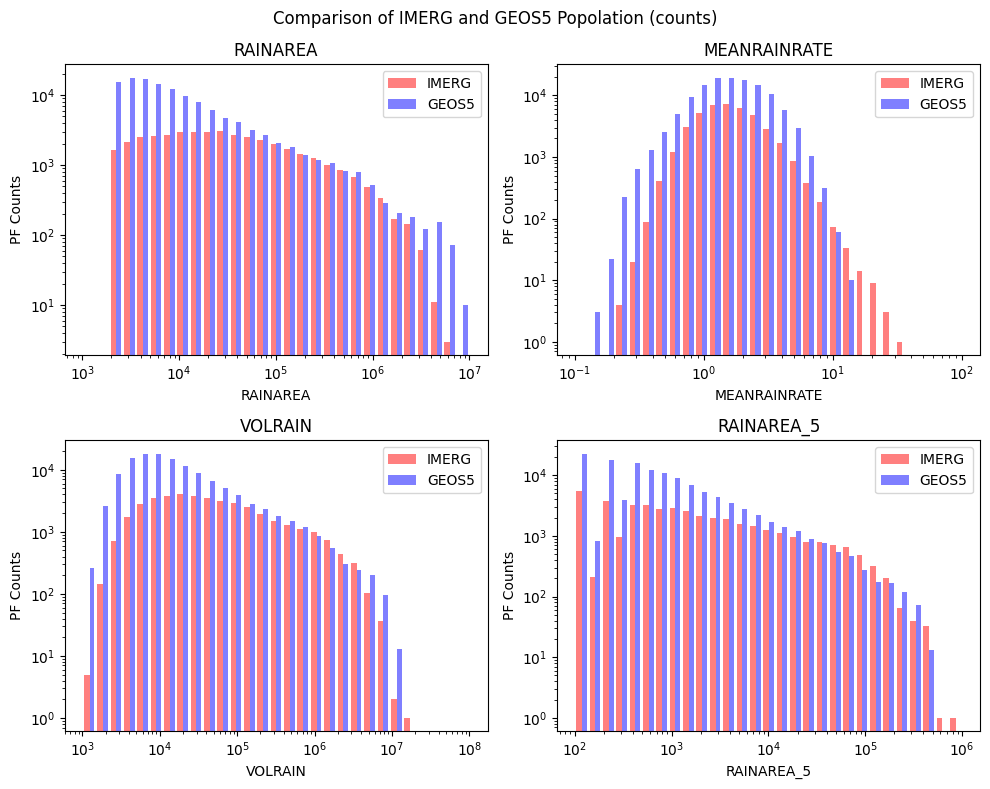

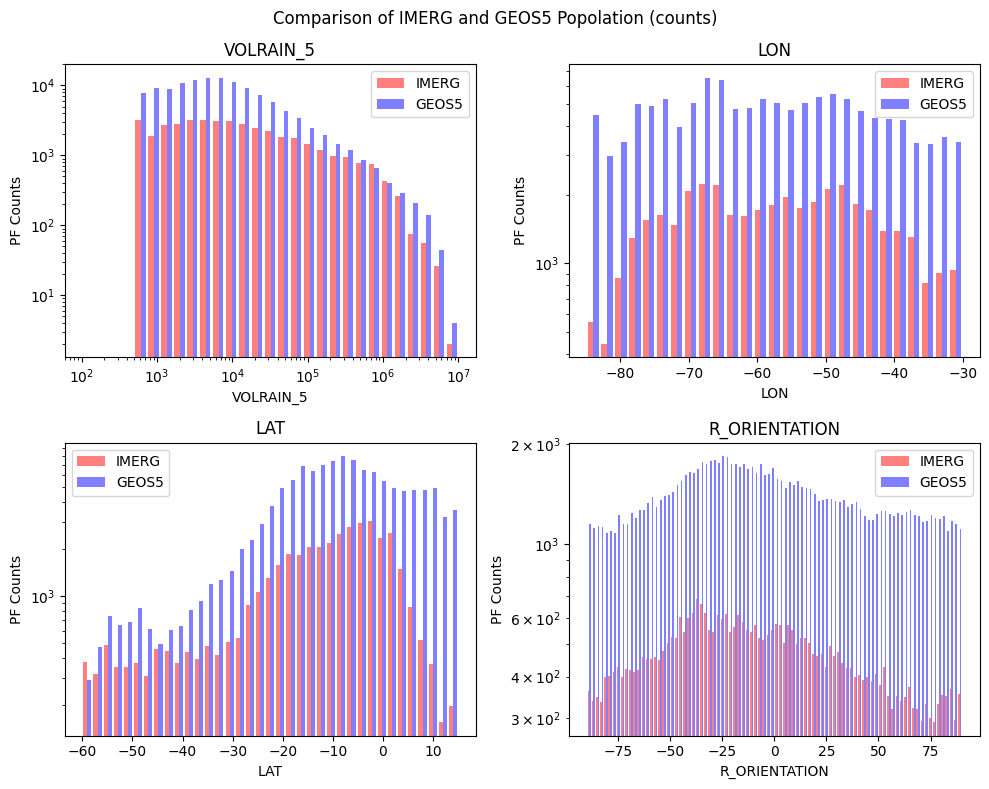

Inside hist2d_dfs arg_list = [['RAINAREA', 'MEANRAINRATE'], ['RAINAREA', 'R_SOLID']]


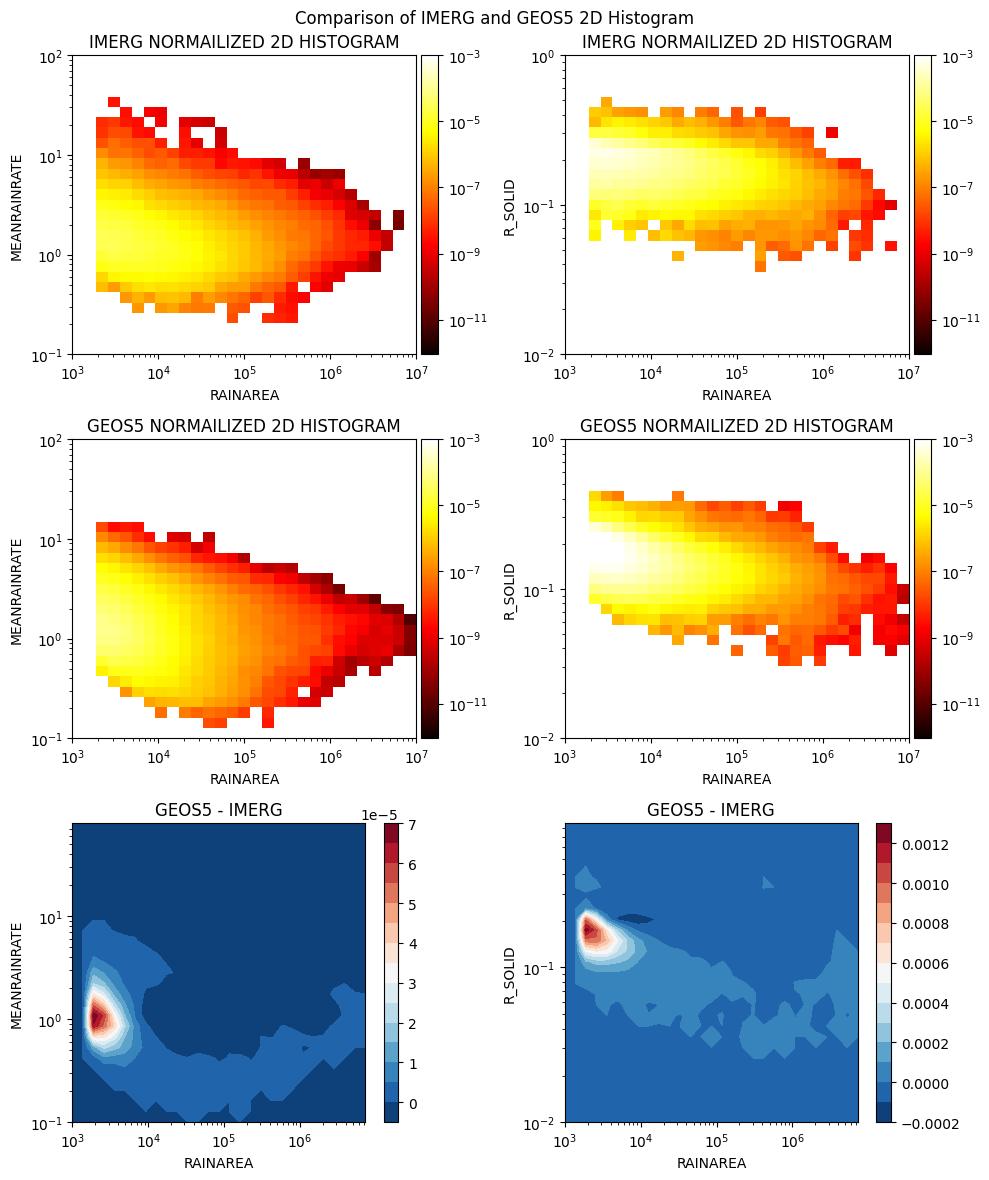

Inside loc_contri_dfs arg_list= [['RAINAREA', 'VOLRAIN', '>', 10000.0], ['R_SOLID', 'VOLRAIN', '<', 0.2]]


/home/ubuntu/anaconda3/envs/ccl/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


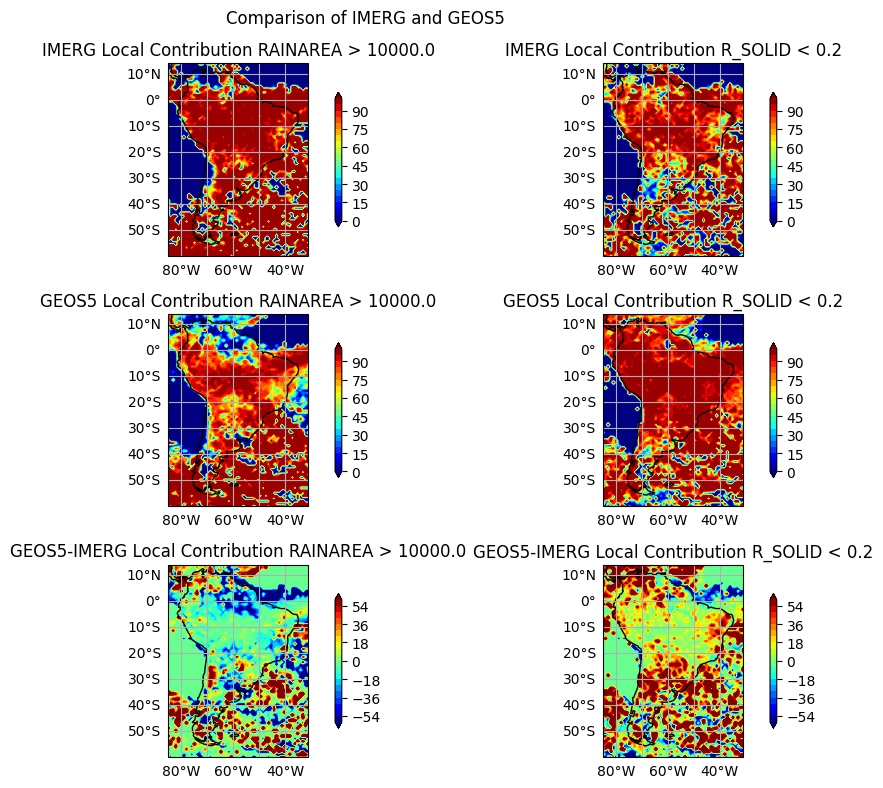

Inside geo2d_dfs geo2d_list= [['RAINAREA', 'count'], ['R_ORIENTATION', 'median'], ['R_SOLID', 'median'], ['VOLRAIN', 'median']]


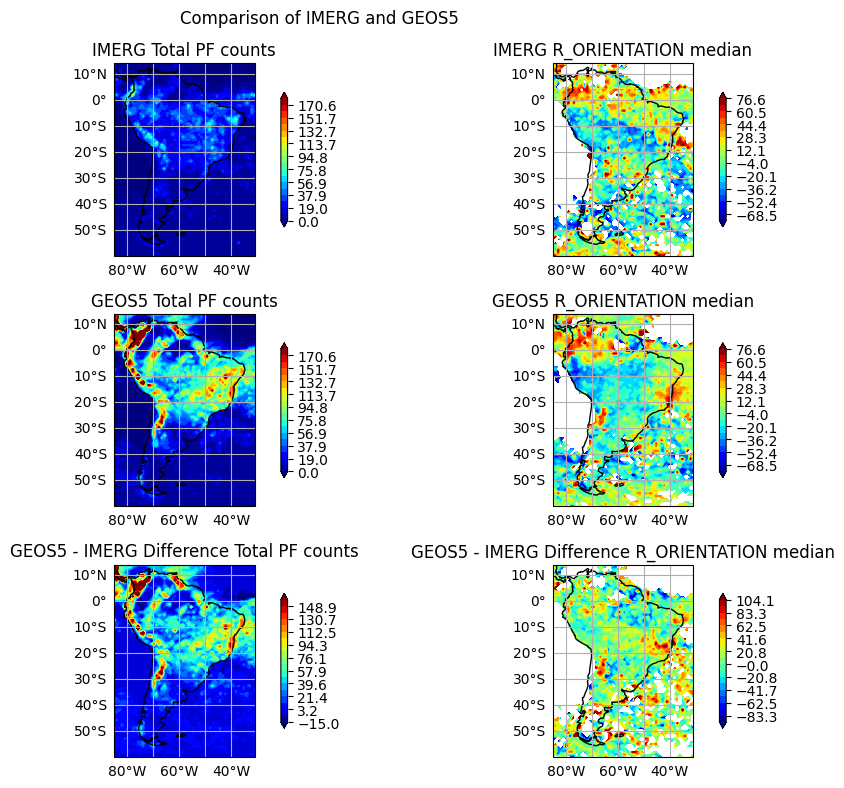

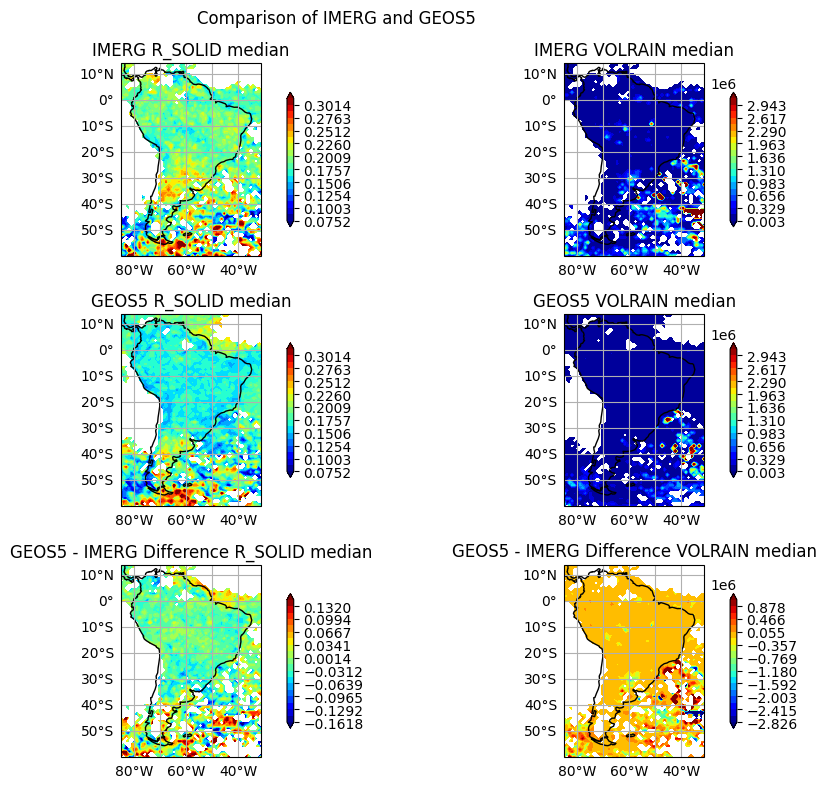

In [13]:
# compare IMERG and GEOS5 subset dfs
#compare_dfs(df_IMERG,df_GEOS5,'IMERG','GEOS5')
#print("Compare PFs with rainarea > 500 $km^2$")
#compare_dfs(df_IMERG_rainarea_500,df_GEOS5_rainarea_500,'IMERG','GEOS5')
#print("Compare PFs with mean rain rate <= 0.2 mm/hr")
#compare_dfs(df_IMERG_meanrainrate_02,df_GEOS5_meanrainrate_02,'IMERG','GEOS5')
#print("Compare PFs with rainarea > 2000 $km^2$")
#compare_dfs(df_IMERG_rainarea_2000,df_GEOS5_rainarea_2000,'IMERG','GEOS5')
#compare_dfs(df_IMERG_r_solid_02,df_GEOS5_r_solid_02,'IMERG','GEOS5')
#compare_dfs(df_IMERG_r_solid_06,df_GEOS5_r_solid_06,'IMERG','GEOS5')
#print("Compare PFs with rainarea > 2000 $km^2$ and rainarea_5 > 200 $km^2$")
#compare_dfs(df_IMERG_MCSs_02,df_GEOS5_MCSs_02,'IMERG','GEOS5')
compare_dfs(df_IMERG_SA_ST,df_GEOS5_SA_ST,'IMERG','GEOS5')